In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [3]:
class InsectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for i, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.image_paths.append(os.path.join(cls_dir, img_name))
                self.labels.append(i)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*32*32, 128),
            nn.ReLU(),
            nn.Linear(128, len(train_dataset.classes))
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = InsectDataset(r"C:\Users\rithi\Downloads\Soft computing Project Resouces\train_insect", transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
from tqdm.notebook import tqdm

# Training Configuration
num_epochs = 10
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Wrap loader with tqdm for auto-progress
    progress_bar = tqdm(train_loader, 
                        desc=f'Epoch {epoch+1}/{num_epochs}', 
                        leave=False)
    
    for images, labels in progress_bar:
        # Forward-Backward Pass
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        running_loss += loss.item()
        progress_bar.set_postfix(loss=f'{running_loss/(progress_bar.n+1):.4f}')
    
    # Save best model (silent)
    epoch_loss = running_loss / len(train_loader)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
#Epoch running

In [ ]:
!pip install tqdm

In [21]:
torch.save({
    'state_dict': model.state_dict(),
    'classes': train_dataset.classes,
    'transform': transform
}, 'insect_modelformal.pt')


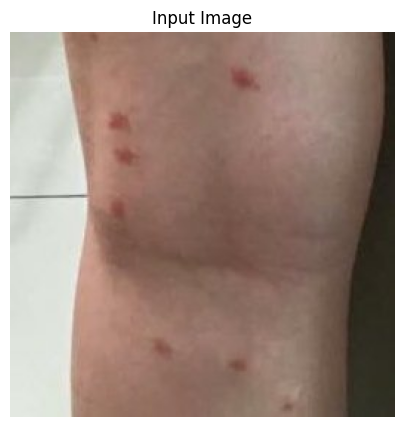


Prediction: abcf
Confidence: 100.0%

Class Probabilities:
- abcf: 100.0%
- ts: 0.0%


In [2]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.serialization

# 1. Load the model with safety checks
try:
    with torch.serialization.safe_globals([transforms.Compose]):
        checkpoint = torch.load(
            'insect_modelformal.pt',
            map_location='cuda' if torch.cuda.is_available() else 'cpu',
            weights_only=False
        )
except Exception as e:
    raise ValueError(f"Model loading failed: {str(e)}") from None

# 2. Verify checkpoint structure
required_keys = {'state_dict', 'classes', 'transform'}
if not all(key in checkpoint for key in required_keys):
    missing = required_keys - set(checkpoint.keys())
    raise KeyError(f"Checkpoint missing required keys: {missing}")

# 3. Define model architecture (must match training)
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64*32*32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 4. Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=len(checkpoint['classes'])).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 5. Prediction function with image display
def predict_and_show(image_path):
    try:
        # Load and display image
        img = Image.open(image_path).convert('RGB')
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()
        
        # Transform and predict
        img_tensor = checkpoint['transform'](img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            confidence, pred = torch.max(probs, 0)
        
        # Print prediction
        print(f"\nPrediction: {checkpoint['classes'][pred.item()]}")
        print(f"Confidence: {confidence.item()*100:.1f}%")
        
        # Show class probabilities
        print("\nClass Probabilities:")
        for i, prob in enumerate(probs):
            print(f"- {checkpoint['classes'][i]}: {prob.item()*100:.1f}%")
            
    except Exception as e:
        print(f"\nError processing image: {str(e)}")

# 6. Execute prediction
image_path = r"C:\Users\rithi\Downloads\Soft computing Project Resouces\train_insect\abcf\fleas_c3 (3).jpg"
predict_and_show(image_path)